# CSC 620 - HA #8
## Text Classification Using Logistic Regression

Mark Kim

Notebook taken from: [David Oluwatobi Peter](https://www.kaggle.com/code/davidoluwatobipeter/sentiment-analysis-logistic-regression-and-lstm/notebook)

Python Libraries Needed for File Opening, Data Analysis, Data Visualization, Data Exploration and Data Cleaning

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Path information for test and train csv's

In [5]:
train = './Corona_NLP_train.csv'
test = './Corona_NLP_test.csv'

Read csv's into dataframes.  Original author uses `latin-1` encoding because
`utf-8` caused errors.

In [6]:
trainOriginal = pd.read_csv(train, encoding='latin-1')
testOriginal = pd.read_csv(test, encoding='latin-1')

Copy dataframes for data manipulation and maintain originals

In [7]:
train = trainOriginal.copy()
test = testOriginal.copy()

---

## Data Exploration and Analysis

Here we look at the data set and explore its attributes.

In [8]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


The original author incorrectly states that the dataset has 7 columns, when in
reality, it has 6 columns (they incorrectly considered the index as part of the dataset)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Besides `Username` and `ScreenName`, all data is non-numeric.  Hence, data needs
to be processed before being used in the models.

The following shows how many null entries exist in each column, and as seen
below, the `location` column contains many blanks (8590).

In [11]:
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Below, we can see the first 25 entries for locations by count.

In [12]:
train['Location'].value_counts()[:60]

London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
New Delhi, India           138
Atlanta, GA                126
New York                   126
Mumbai, India              109
Worldwide                  101
Lagos, Nigeria              99
Houston, TX                 98
Austin, TX                  98
Texas, USA                  98
London, UK                  96
Toronto                     91
Los Angeles                 89
Nairobi,

Locations are split and only the first portion is taken into account since there
are duplicate entries (e.g. New York, NY & New York, USA).

In [13]:
#splitting location into word pairs
train['Location'] = train['Location'].str.split(",").str[0]
test['Location'] = test['Location'].str.split(",").str[0]

In [14]:
train['Location'].value_counts()[:60]

London            1247
New York           709
United States      530
Washington         504
Los Angeles        402
Toronto            346
United Kingdom     342
India              276
Chicago            262
England            255
UK                 246
USA                231
Australia          230
California         211
San Francisco      206
Sydney             202
New Delhi          201
Melbourne          199
Canada             198
Mumbai             197
Boston             197
Atlanta            165
Global             159
Houston            156
Texas              145
Lagos              136
Austin             130
Florida            121
Seattle            120
Nairobi            117
Dallas             115
Philadelphia       114
Manchester         111
Vancouver          106
Scotland           104
New Jersey         103
Worldwide          101
San Diego           99
New York City       95
Dubai               91
Singapore           88
South Africa        87
Portland            86
Denver     

This data contains approximately one month of tweets, so any model built upon
this information may not apply well to recent tweets making this a decayed
model.  Because of the nature of twitter, model decay happens rapidly.

In [15]:
train['TweetAt'].value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

The counts of each sentiment in the dataset.

In [16]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

---

## Visual Representation of the Training Set

### Tweeted Locations

This graph represents the quantity of tweets by location

Text(0.5, 1.0, 'Tweeted locations')

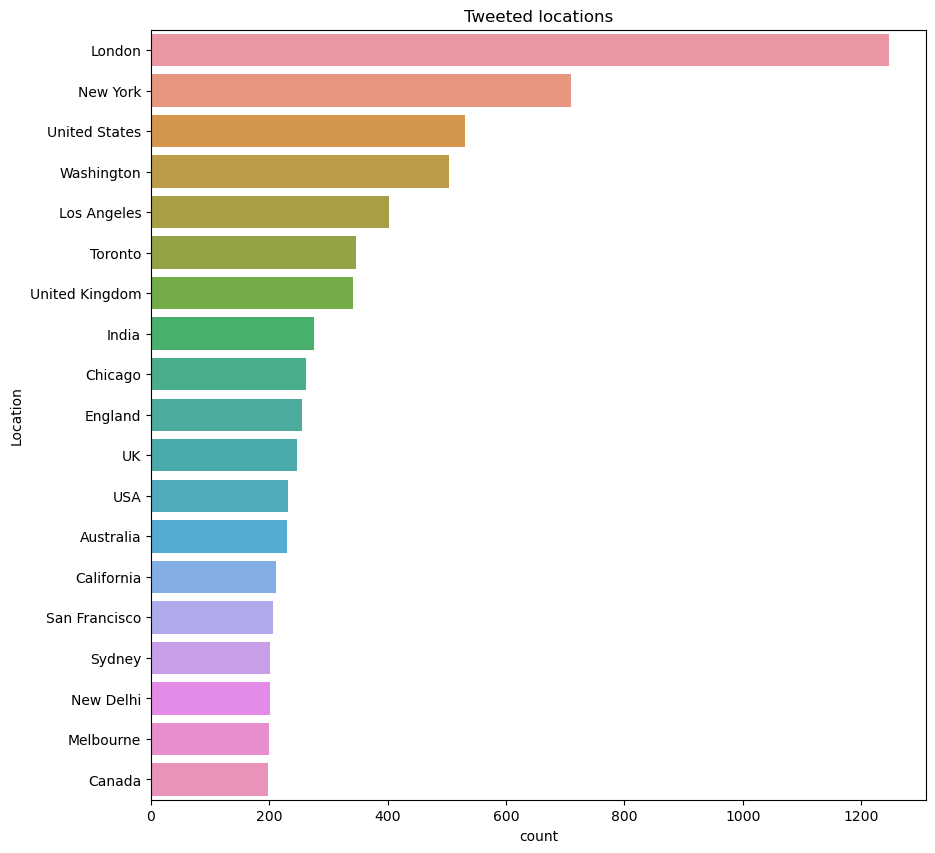

In [17]:
plt.figure(figsize=(10,10))
sns.countplot(y='Location',data=train,order=train.Location.value_counts().iloc[
    0:19].index).set_title("Tweeted locations")

### Sentiment Counts

The following graph shows the count of tweets belonging to each sentiment class.

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

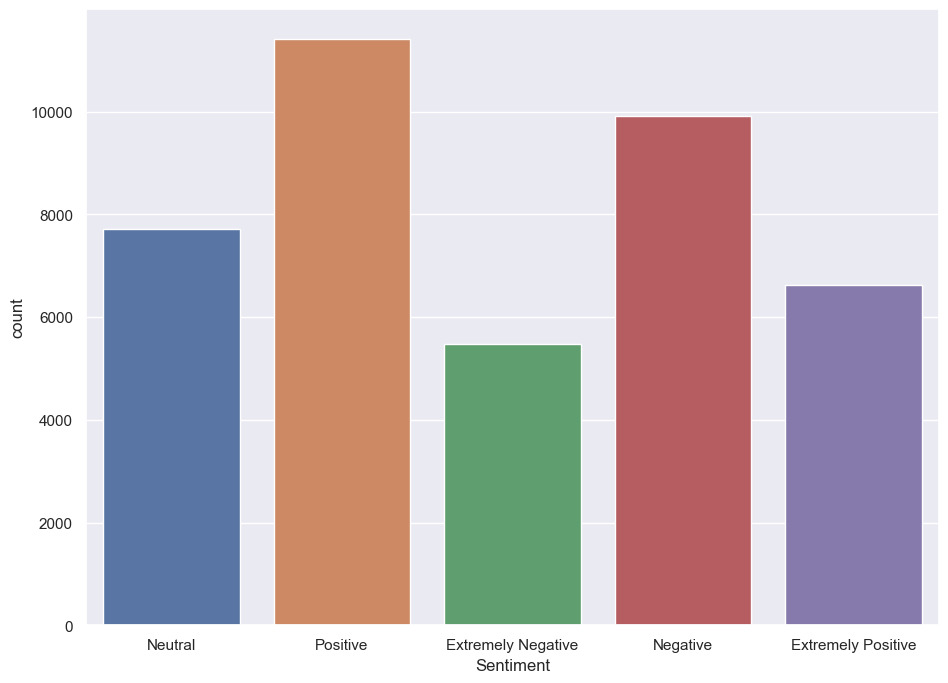

In [18]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,8)})
sns.countplot(x=train['Sentiment'])

### Sentiment Percentage

This is another graph that represents the percentage of tweets belonging to each sentiment.

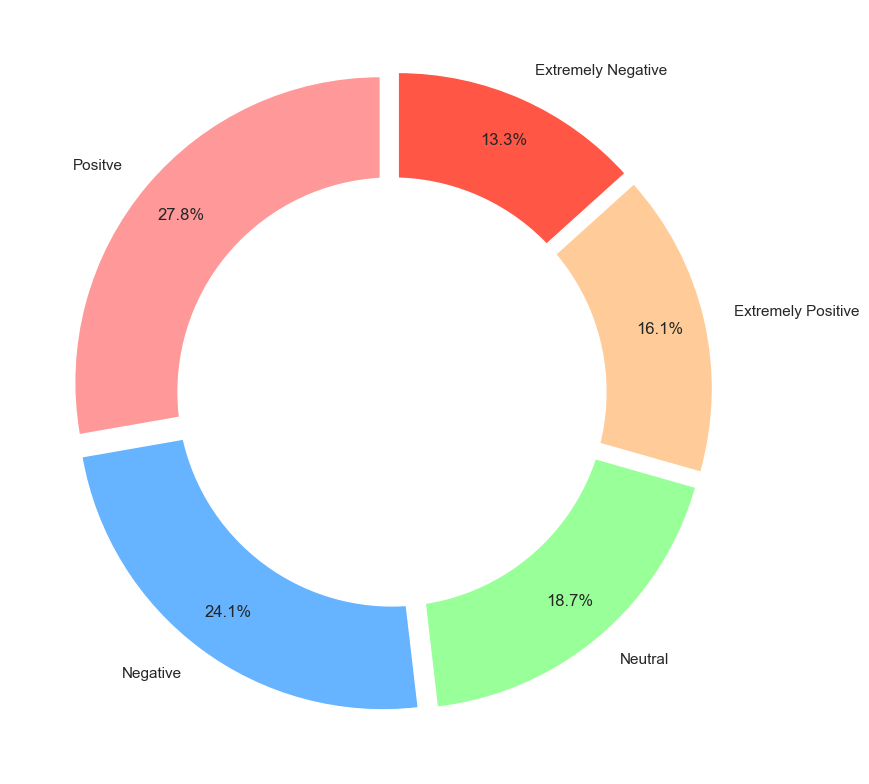

In [19]:
labels = ['Positve', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ff5645']
explode = (0.05,0.05,0.05,0.05,0.05) 
plt.pie(train.Sentiment.value_counts(), colors = colors, labels=labels,
        autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
centreCircle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)
plt.tight_layout()
plt.show()

### Sentiment and Location of each tweet

In [20]:
plotDf = train.iloc[:,[2,5]] #[:,[2,5]] is the location and sentiment columns
plotDf

,Location,Sentiment
0,London,Neutral
1,UK,Positive
2,Vagabonds,Positive
3,NaN,Positive
4,NaN,Extremely Negative
...,...,...
41152,Wellington City,Neutral
41153,NaN,Extremely Negative
41154,NaN,Positive
41155,NaN,Neutral


### Sentiment Analysis of Top Five Location

The following graph illustrates the sentiment count at the top 5 locations of
tweets.  Positive sentiment tweets outnumber all other sentiments in all
locations; this means that the dataset is biased towards positive sentiments.

<AxesSubplot:title={'center':'Sentiment Categories of the First 5 Top Locations'}, xlabel='Location', ylabel='count'>

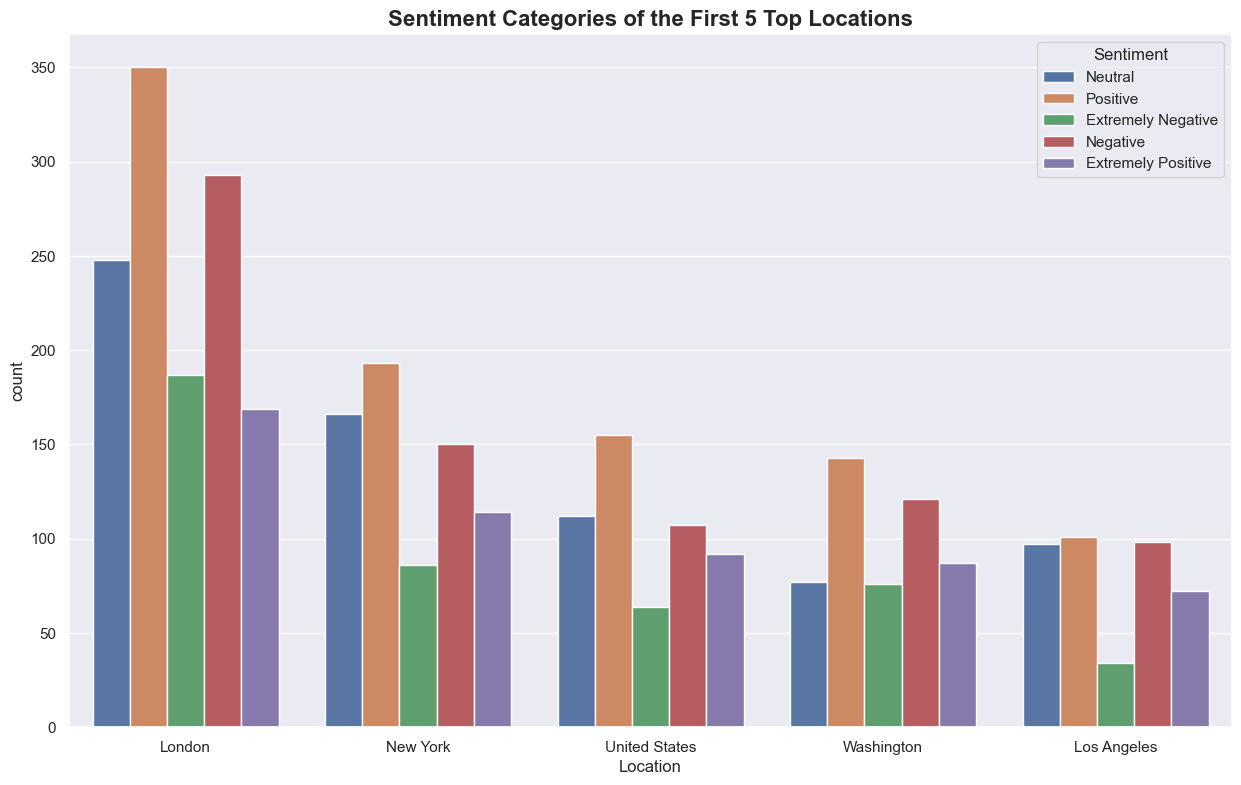

In [21]:
sns.set(rc={'figure.figsize':(15,9)})
gg = train.Location.value_counts()[:5].index
plt.title('Sentiment Categories of the First 5 Top Locations', fontsize=16, fontweight='bold')
sns.countplot(x = 'Location', hue = 'Sentiment', data = plotDf, order = gg)

---

## Data Processing for Machine Learning Algorithms

Here the author preprocesses the data to be fed into the Machine Learning Algorithm(s).

### Maintain Test and Train sets

The author decides to keep the same train and test set as provided; to do this,
each is labeled in its respective dataframe.  The full concatenated set is then
processed as a whole.

In [63]:
train['Identity'] = 0
test['Identity'] = 1 
covid = pd.concat([train, test])
covid_o = pd.concat([train, test])
covid.reset_index(drop=True, inplace=True)

In [44]:
covid.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


The author decides to re-class sentiments so that `extremely positive` and
`extremely negative` sentiments are mapped to `positive` and `negative`
sentiments respectively.  From this point on, analysis will only be able to
predict between 3 classes rather than the 5 provided.

In [64]:
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Positive', 'Positive')
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Negative', 'Negative')

The screen and username columns are dropped since they'll have no effect on the accuracy of the model.

In [65]:
covid = covid.drop('ScreenName', axis=1)
covid = covid.drop('UserName', axis=1)
covid

,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,0
...,...,...,...,...,...
44950,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,1
44951,Farmington,16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,1
44952,Haverford,16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,1
44953,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Negative,1


The following commented-out code would replace all null entries with "unknown".
This would be useful only if location data was being used as a feature for
sentiment class analysis.

In [47]:
# covid['Location'].fillna('Unknown', inplace=True)

# covid.isnull().sum() would have being used to check and confirm

## Visualizing the Concatenated Data Set

The following visualizations show the new dataset with extreme sentiments mapped
to their moderate counterparts.

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

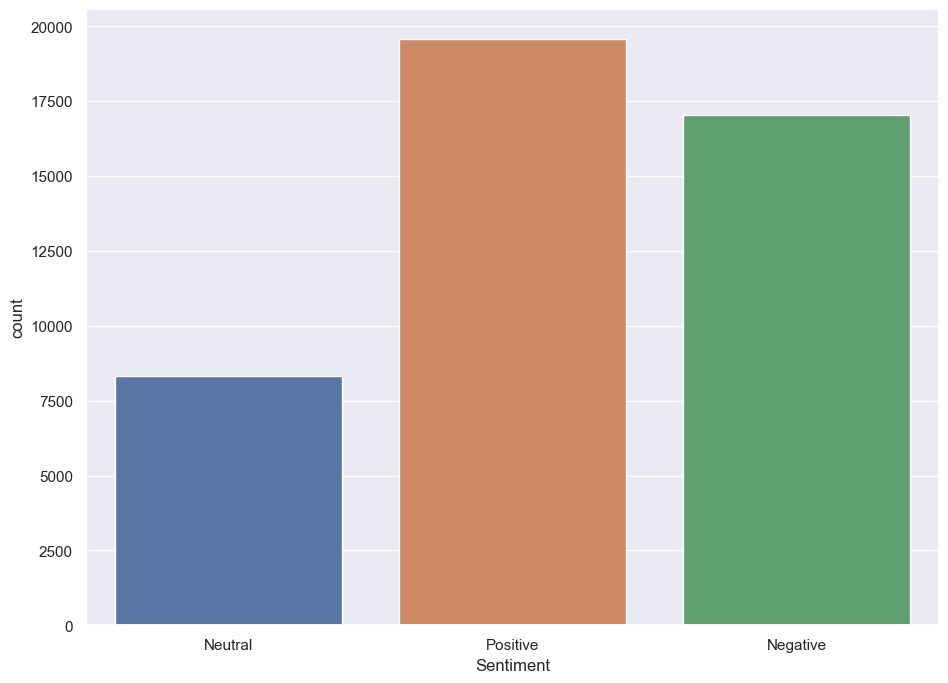

In [48]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,8)})
sns.countplot(x=covid['Sentiment'])

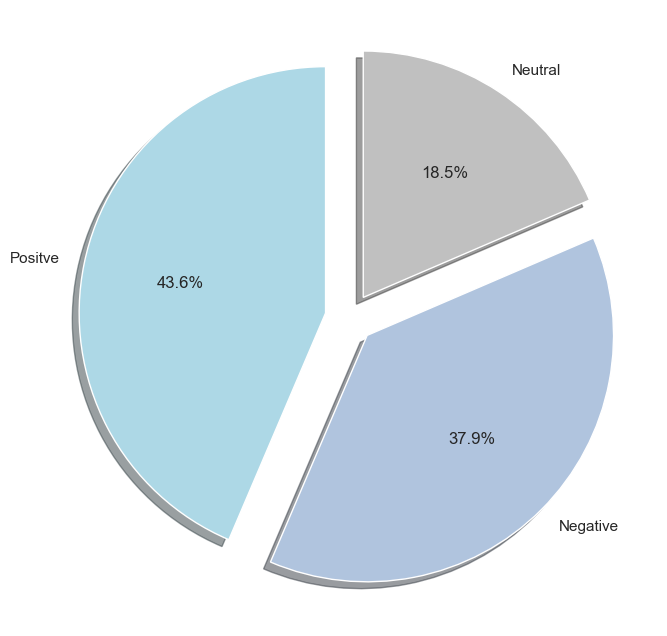

In [49]:
labels = ['Positve', 'Negative', 'Neutral']
colors = ['lightblue','lightsteelblue','silver']
explode = (0.1, 0.1, 0.1)
plt.pie(covid.Sentiment.value_counts(), colors = colors, labels=labels,
        shadow=300, autopct='%1.1f%%', startangle=90, explode = explode)
plt.show()

Text(0.5, 1.0, 'Tweeted locations')

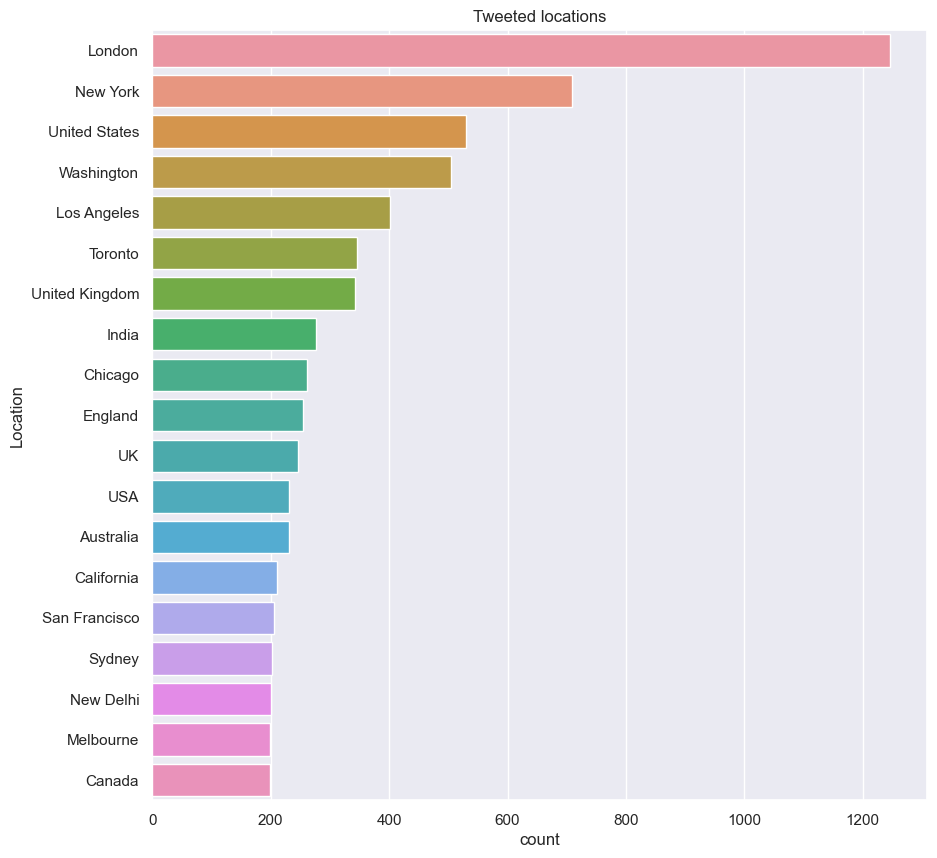

In [50]:
plt.figure(figsize=(10,10))
sns.countplot(y='Location',data=train,order=train.Location.value_counts().iloc[
    0:19].index).set_title("Tweeted locations")

### Remapping Sentiments to Integer Values

The sentiment categories are remapped into integer values for analysis purposes.

Neutral: 0, Positive: 1, Negative: 2

In [66]:
covid['Sentiment'] = covid['Sentiment'].map({'Neutral':0, 'Positive':1, 'Negative':2})

## Text Normalization

Top mentions and hashtags in the tweets are extracted and analyzed, after which
they, along with stop words, are removed.

### Hashtags

As can be seen below, most of the hashtags are centered around COVID-19 (and
it's analogues), safety protocols, or lifestyle changes that occurred as a
result of it.

In [67]:
hashTags=covid['OriginalTweet'].str.extractall(r"(#\S+)")
hashTags = hashTags[0].value_counts()
hashTags[:50]

#coronavirus            13345
#Covid_19                3900
#COVID19                 3470
#Coronavirus             2236
#COVID2019               1772
#toiletpaper             1376
#covid19                 1133
#COVID?19                 893
#CoronaCrisis             720
#CoronaVirus              669
#CoronavirusPandemic      626
#SocialDistancing         615
#covid_19                 477
#CoronavirusOutbreak      442
#pandemic                 410
#panicbuying              403
#CoronaVirusUpdate        341
#lockdown                 340
#Covid19                  336
#StayHomeSaveLives        334
#retail                   329
#coronavirus.             325
#StayAtHome               324
#supermarket              322
#StayHome                 312
#corona                   301
#StopHoarding             275
#socialdistancing         266
#food                     239
#COVID-19                 239
#StopPanicBuying          236
#COVID                    235
#shopping                 228
#covid19UK

### Mentions

Some correlation can be found between prominent figures and companies and COVID
tweets, but there is no indication as to whether this information would be
useful in sentiment analysis.

In [68]:
mentions = train['OriginalTweet'].str.extractall(r"(@\S+)")
mentions = mentions[0].value_counts()
mentions[:50]

@realDonaldTrump    239
@Tesco              180
@sainsburys         152
@BorisJohnson       141
@narendramodi       110
@asda               103
@amazon              95
@PMOIndia            94
@Morrisons           87
@piersmorgan         84
@YouTube             83
@waitrose            70
@CNN                 56
@AldiUK              52
@FTC                 48
@Walmart             47
@CDCgov              44
@NYGovCuomo          42
@BBCNews             41
@SkyNews             40
@LidlGB              38
@nytimes             37
@ssupnow             37
@MailOnline          36
@WSJ                 34
@Coles               33
@McKinsey            33
@10DowningStreet     31
@kroger              31
@WHO                 30
@woolworths          30
@eBay                30
@MattHancock         28
@Target              27
@GMB                 26
@POTUS               26
@GavinNewsom         25
@NHSuk               24
@Canon_India         22
@GoogleNews          22
@Publix              22
@Ocado          

### RegEx Text Normalization

A python regex function to clean the tweets by removing hashtags, mentions, urls, digits and stop words.

In [69]:
import re

def clean(text):
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('r<.*?>',' ', text)
    text = text.split()
    text = " ".join([word for word in text if not word in stopWord])
    
    return text

In [70]:
import nltk
from nltk.corpus import stopwords

#### Stopword Removal

English stopwords are removed (via the nltk stopwords corpus).

In [71]:
stopWord = stopwords.words('english')

In [73]:
covid['OriginalTweet'] = covid['OriginalTweet'].apply(lambda x: clean(x))

In [74]:
covid.head()

,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,London,16-03-2020,,0,0
1,UK,16-03-2020,advice Talk neighbours family exchange phone n...,1,0
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,1,0
3,NaN,16-03-2020,"My food stock one empty... PLEASE, panic, THER...",1,0
4,NaN,16-03-2020,"Me, ready go supermarket outbreak. Not I'm par...",2,0


#### Features Dropped

Features deemed unnecessary by the author are dropped (location and tweet date).

In [75]:
covid = covid[['OriginalTweet','Sentiment','Identity']]
covid.head()

,OriginalTweet,Sentiment,Identity
0,,0,0
1,advice Talk neighbours family exchange phone n...,1,0
2,Coronavirus Australia: Woolworths give elderly...,1,0
3,"My food stock one empty... PLEASE, panic, THER...",1,0
4,"Me, ready go supermarket outbreak. Not I'm par...",2,0


---

## Further Pre-processing for Analysis

Libraries and Frame Works Needed for Further Data Processing, Building a Logistic Regression Model and it's Evaluation

In [76]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

### Tokenization and Lemmatization

Machine learning models finds statistical relations, therefore the data is
tokenized and vectorized as part of the data preprocessing step.

The tweets are tokenized, and the words within them are lemmatized so that the
root words are analyzed.

In [78]:
covid_o = covid.copy()

In [91]:
covid = covid_o.copy()

In [92]:
mylist = [nltk.word_tokenize(text) for text in covid.OriginalTweet]
covid['Corpus'] = mylist

In [ ]:
lemma = nltk.WordNetLemmatizer()
covid.loc[:, 'Corpus'] = covid.apply(lambda x: [lemma.lemmatize(word) for word in x.Corpus], axis=1)
covid.loc[:, 'Corpus'] = covid.apply(lambda x: " ".join(x.Corpus),axis=1)

In [94]:
covid.head()

,OriginalTweet,Sentiment,Identity,Corpus
0,,0,0,
1,advice Talk neighbours family exchange phone n...,1,0,advice Talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths give elderly...,1,0,Coronavirus Australia : Woolworths give elderl...
3,"My food stock one empty... PLEASE, panic, THER...",1,0,"My food stock one empty ... PLEASE , panic , T..."
4,"Me, ready go supermarket outbreak. Not I'm par...",2,0,"Me , ready go supermarket outbreak . Not I 'm ..."


The data sets are split back into a training and test set.

In [101]:
train = covid[covid.Identity==0]
test = covid[covid.Identity==1]
train = train.drop('Identity',axis=1)
test = test.drop('Identity',axis=1)
test = test.reset_index(drop=True)

In [102]:
train.head()

,OriginalTweet,Sentiment,Corpus
0,,0,
1,advice Talk neighbours family exchange phone n...,1,advice Talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths give elderly...,1,Coronavirus Australia : Woolworths give elderl...
3,"My food stock one empty... PLEASE, panic, THER...",1,"My food stock one empty ... PLEASE , panic , T..."
4,"Me, ready go supermarket outbreak. Not I'm par...",2,"Me , ready go supermarket outbreak . Not I 'm ..."


In [103]:
test.head()

,OriginalTweet,Sentiment,Corpus
0,TRENDING: New Yorkers encounter empty supermar...,2,TRENDING : New Yorkers encounter empty superma...
1,"When I find hand sanitizer Fred Meyer, I turne...",1,"When I find hand sanitizer Fred Meyer , I turn..."
2,Find protect loved ones . ?,1,Find protect loved one . ?
3,buying hits City anxious shoppers stock food&a...,2,buying hit City anxious shopper stock food & a...
4,One week everyone buying baby milk powder next...,0,One week everyone buying baby milk powder next...


The train set is split to get a validation set.

In [104]:
XTrain = train.Corpus
yTrain = train.Sentiment

XTest = test.Corpus
yTest = test.Sentiment

XTrain, XVal, yTrain, yVal = train_test_split(XTrain, yTrain, test_size=0.2,random_state=42)

In [105]:
XTrain.shape, XVal.shape, yTrain.shape, yVal.shape, XTest.shape, yTest.shape

((32925,), (8232,), (32925,), (8232,), (3798,), (3798,))

### CountVectorizer

This section of the notebook uses sklearn's `CountVectorizer` to convert an array of texts into a matrix
of token counts.  In this case, it is initialized with the options as follows:
1. `stop_words`: it will remove the stop words from the built-in stop word list
   for english
2. `ngram_range`: it will count unigrams and bigrams (the tuple defines the
   lower and upper boundry for the range of n-values for n-grams)
3. `min_df`: this value will ignore terms that do not reach the threshold counts
   (in this case, if word counts are strictly less than 5)

Finally, the vectorizer learns the vocabulary dictionary of all tokens in the
corpus fed to it (in this case, `covid['Corpus']`).

In [106]:
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(covid.Corpus)

#### Transform

The transform function of the vectorizer then uses the vocabulary to extract the
token counts of the train and test sets.

In [107]:
XTrainVec = vectorizer.transform(XTrain)
XValVec = vectorizer.transform(XVal)
XTestVec = vectorizer.transform(XTest)

### Logistic Regression

The particular machine learning method used below is the Logistic Regression
that we have been covering in class for the last several weeks.

Since we have a multinomial class evaluation (3 classes), we have an objective function (estimator) which is a softmax function:
$$ \hat{y_i} = P(y=i|x) = \operatorname{softmax}(z_i) =
\frac{e^{\vec{w_i}\cdot\vec{x}+{b_i}}}{\sum_{j=1}^k
e^{\vec{w_j}\cdot\vec{x}+{b_j}}} \quad 1 \leq i \leq k $$

Note that this function is guaranteed to return a probability (e.g. a value
between 0 and 1).

In [112]:
logReg = LogisticRegression(random_state=42, max_iter=400)

### Cross Validation

This allows the scoring of an estimator (e.g. precision).  Here, I increased the
`max_iter` to 400 because the default of 100 was not converging.

In [110]:
cross_val_score(LogisticRegression(random_state=42, max_iter=400),
                XTrainVec, yTrain, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished


0.7981173751604623

Similarly, I increased the max number of iterations to 400 because the author's
notebook would not converge with the default number of iterations.

In [113]:
model = logReg.fit(XTrainVec, yTrain)

This classification report tells us the precision, recall, and f1-score of the
model with the test set `XVal` and `yVal`.

In [114]:
print(classification_report(yVal, model.predict(XValVec)))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1553
           1       0.83      0.84      0.83      3617
           2       0.82      0.79      0.80      3062

    accuracy                           0.80      8232
   macro avg       0.78      0.79      0.78      8232
weighted avg       0.80      0.80      0.80      8232



#### Fine Tuning the Logistic Regression Model

The author uses `GridSearchCV` to test many hyperparameters and evaluate the
performance of each through cross-validation.

In [115]:
penalty = ['l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

logRegGrid = GridSearchCV(logReg, hyperparameters, cv=5, verbose=0)

In [116]:
bestModel = logRegGrid.fit(XTrainVec, yTrain)

/opt/homebrew/Caskroom/miniconda/base/envs/csc620/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniconda/base/envs/csc620/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [117]:
# Best hyperparameters combination

print('Best Penalty:', bestModel.best_estimator_.get_params()['penalty'])
print('Best C:', bestModel.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [118]:
# Final Logistic Regression model performance

yPred = bestModel.predict(XTestVec)

In [119]:
print(classification_report(yTest, bestModel.predict(XTestVec)))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       619
           1       0.79      0.80      0.80      1546
           2       0.80      0.78      0.79      1633

    accuracy                           0.77      3798
   macro avg       0.75      0.75      0.75      3798
weighted avg       0.77      0.77      0.77      3798



### CountVectorizer -- AGAIN

This section of the notebook uses sklearn's `CountVectorizer` to convert an array of texts into a matrix
of token counts.  In this case, it is initialized with the options as follows:
1. `stop_words`: it will remove the stop words from the built-in stop word list
   for english
2. `ngram_range`: it will count unigrams and bigrams (the tuple defines the
   lower and upper boundry for the range of n-values for n-grams)
3. `min_df`: this value will ignore terms that do not reach the threshold counts
   (in this case, if word counts are strictly less than 5)

Finally, the vectorizer learns the vocabulary dictionary of all tokens in the
corpus fed to it (in this case, `covid['Corpus']`).

### Evaluation -- Precision, Recall, F-1

Precision is the percentage of the class predictions that match the ground
truth, which is calculated by:
$$ P = \frac{tp}{tp + fp} $$
where $tp$ is the number of positive predictions and $fp$ is the number of
negative predictions.

Recall, on the other hand, is the percentage of ground truth classes that are
predicted correctly, which can be calculated by
$$ R = \frac{tp}{tp + fn} $$
where $tp$ is the number of positive predictions and $fn$ is the number of
incorrect negative predictions.

Finally, the F-1 score assesses the precision vs. recall tradeoff (weighted
harmonic mean) which can be calculated by
$$ F = \frac{(\beta^2 + 1)PR}{\beta^2P + R} $$
where $0 \leq \beta \leq \infty$.

In [ ]:
# Precision deals with the accuracy of the positive predictions.
# precision = TP / TP + FP
# TP is the number of true positives, and FP is the number of false positives.

# Recall, also called sensitivity or true positive rate (TPR) is the ratio of positive instances that
# are correctly detected by the classifier.
# recall = TP / TP + FN
# TP is the number of true positives FP is the number of false positives and FN is the number of
# false negatives.

# But the metric of choice to measure the performance of the logistic regression model in this
# project is the F1-score.The F1 score is the harmonic mean of precision and recall.
# Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low
# values. As a result, the classifier will only get a high F1 score if both recall and precision are
# high.

In [ ]:
# A less concise metric also available is the confusion matrix. The general idea involves counting
# the number of times instances of class A are classified as class B.

#  Implementation:

# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import cross_val_predict

# yPred = bestModel.predict(XTestVec)
# print(confusion_matrix(yTest, yPred))

# NB: it's possible that classification metrics wont't be able to handle a mix of multilabel-indicator
# and multiclass targets.

---

# The below is not necessary for this assignment

LONG SHORT TERM MEMORY (LSTM) MODEL

The underlying Long Short-Term Memory (LSTM) algorithm was developed by Hochreiter and Schmidhuber
in 1997; it was the culmination of their research on the vanishing gradient problem. This layer is a variant of the SimpleRNN layer; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact,
when you need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing (Francois Chollet, Deep Learning with Python).

Libraries and Frame Works Needed for Further Data Processing, Building a LSTM Model and it's Evaluation

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
lines = []
for line in train['Corpus']:
    lines.append(line)
    
len(lines)

In [ ]:
tokenizer = Tokenizer(num_words=5000, lower=True) # Number of words to consider as features
tokenizer.fit_on_texts(train['Corpus'].values)
wordIndex = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % (wordIndex))

In [ ]:
# Turns the lists of integers into a 2D integer tensor of shape (numWords, maxlen)
XTrain = tokenizer.texts_to_sequences(train['Corpus'].values)
XTrain = pad_sequences(XTrain, maxlen=30) # Cuts off the texts after this number of words

XTest = tokenizer.texts_to_sequences(test['Corpus'].values)
XTest = pad_sequences(XTest, maxlen=30)

In [ ]:
# The tokenizer selects the most common 5000 words. The sequences are padded so that they all have
# a uniform length of 30.

In [ ]:
XTrain.shape, XTest.shape

In [ ]:
yTrain = to_categorical(train['Sentiment'], 3)
yTest = to_categorical(test['Sentiment'], 3)

NEURAL NETWORK

The neural network consists of one embedding layer followed by one LSTM layer with 200 units. A Dropout layer is added for regularizatin to prevent overfitting of the model. The neural architecture ends with a Dense layer having three units to generate the output or prediction classes. The activation used is softmax since it is a single label, multi class problem.

A prominent or distinguishing feature in this neural construct is the Embedding layer. The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors. It’s effectively a dictionary lookup.

In [ ]:
model= models.Sequential()
model.add(layers.Embedding(wordIndex, 128, input_length=1000))
model.add(layers.LSTM(200))
model.add(Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=0.01),
              metrics=['accuracy'])

In [ ]:
# The callbacks parameter implemented monitors the validation loss and stops the training process
# once there is no apparent improvement for 10 epochs. It will also restore the best version of the
# model recorded during training.

In [ ]:
history = model.fit(XTrain ,yTrain, batch_size=250, epochs=100, validation_split=0.2,
         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Visualizing the Loss/Accuracy of the Model In-Between Epochs

In [ ]:
accuracy = history.history['accuracy']
valAccuracy = history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plot = ax1.plot(epochs, accuracy, 'bo', label='Training Accuracy')
ax1.plot(epochs, valAccuracy, 'b', label='Validation Accuracy')
ax1.set(title='Training/Validation Accuracy', ylabel='Accuracy')
ax1.legend()

plot = ax2.plot(epochs, loss, 'bo', label='Training Loss')
ax2.plot(epochs, valLoss, 'b', label='Validation Loss')
ax2.set(title='Training/Validation Loss', ylabel='Loss', xlabel='Epochs')
ax2.legend()

fig.suptitle('Loss/Accuracy of the LSTM Sentiment Classifier', fontsize=16, fontweight = 'bold')

In [ ]:
# The model still overfits: In the absence of more data, the overfitting being experienced can probably be
# minimized by reducing the number of layers or by reducing the number of units used in the neural
# architecture. The Dropout can also be increased. Weight regularization via the keras
# kernel_regularizer can also be implemented.

In [ ]:
results = model.evaluate(XTest, yTest)

In [ ]:
print(classification_report(np.argmax(yTest, 1), model.predict_classes(XTest)))

In [ ]:
# A test accuracy score of 0.84 gives a much improved performance compared to the Logistic Regression
# algorithm. A normal slight drop from the 0.87 recorded during validation evaluation.

In [ ]:
model.save('./LSTM classifier.h5')
keras.models.load_model('./LSTM classifier.h5')

---

# END OF NOTEBOOK EXPLANATION -- A repeat of previous cells

### CountVectorizer

This section of the notebook uses sklearn's `CountVectorizer` to convert an array of texts into a matrix
of token counts.  In this case, it is initialized with the options as follows:
1. `stop_words`: it will remove the stop words from the built-in stop word list
   for english
2. `ngram_range`: it will count unigrams and bigrams (the tuple defines the
   lower and upper boundry for the range of n-values for n-grams)
3. `min_df`: this value will ignore terms that do not reach the threshold counts
   (in this case, if word counts are strictly less than 5)

Finally, the vectorizer learns the vocabulary dictionary of all tokens in the
corpus fed to it (in this case, `covid['Corpus']`).

### Evaluation -- Precision, Recall, F-1

Precision is the percentage of the class predictions that match the ground
truth, which is calculated by:
$$ P = \frac{tp}{tp + fp} $$
where $tp$ is the number of positive predictions and $fp$ is the number of
negative predictions.

Recall, on the other hand, is the percentage of ground truth classes that are
predicted correctly, which can be calculated by
$$ R = \frac{tp}{tp + fn} $$
where $tp$ is the number of positive predictions and $fn$ is the number of
incorrect negative predictions.

Finally, the F-1 score assesses the precision vs. recall tradeoff (weighted
harmonic mean) which can be calculated by
$$ F = \frac{(\beta^2 + 1)PR}{\beta^2P + R} $$
where $0 \leq \beta \leq \infty$.